In [1]:
%matplotlib inline

In [2]:
# HACK: needed to manually import sys.path from ipython repl, for some reason it doesn't work on my host otherwise
import sys
sys.path = ['', '/Users/naveed/scratch/fraud_detection_project/venv/bin', '/Users/naveed/scratch/fraud_detection_project/venv/lib/python27.zip', '/Users/naveed/scratch/fraud_detection_project/venv/lib/python2.7', '/Users/naveed/scratch/fraud_detection_project/venv/lib/python2.7/plat-darwin', '/Users/naveed/scratch/fraud_detection_project/venv/lib/python2.7/plat-mac', '/Users/naveed/scratch/fraud_detection_project/venv/lib/python2.7/plat-mac/lib-scriptpackages', '/Users/naveed/scratch/fraud_detection_project/venv/lib/python2.7/lib-tk', '/Users/naveed/scratch/fraud_detection_project/venv/lib/python2.7/lib-old', '/Users/naveed/scratch/fraud_detection_project/venv/lib/python2.7/lib-dynload', '/Users/naveed/anaconda2/lib/python2.7', '/Users/naveed/anaconda2/lib/python2.7/plat-darwin', '/Users/naveed/anaconda2/lib/python2.7/lib-tk', '/Users/naveed/anaconda2/lib/python2.7/plat-mac', '/Users/naveed/anaconda2/lib/python2.7/plat-mac/lib-scriptpackages', '/Users/naveed/scratch/fraud_detection_project/venv/lib/python2.7/site-packages', '/Users/naveed/scratch/fraud_detection_project/venv/lib/python2.7/site-packages/IPython/extensions', '/Users/naveed/.ipython']

In [3]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))

from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split

from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

pd.set_option('max_colwidth', -1)

In [4]:
import xgboost

In [5]:
pdf = pd.read_csv('./creditcard.csv')

# Notes:
 - Reduced FeatureSet: 28 Features determined from prior PCA analysis. Original features were scrubbed for user anonymity
 - Time & Amount are the only two original features
 - Total Samples in DataSet: 284,807. Number of Fraudalent transactions: 492 (0.172%) of all transactions. Represented by "Class" Feature
 
# Goal:
 - explore the data and understand the data
 - explore the different machine learning methods and comparing their results against each other
 - use some ml validation techniques to understand the strengths and weaknesses of each ml method

In [6]:
numerical_features_only = sorted(list(set(pdf.columns.tolist()) - set(['Time', 'Amount', 'Class'])), key=lambda x: int(x[1:]))

## Fraud Class EDA

In [7]:
fraud_df = pdf.loc[pdf.Class == 1]

In [8]:
fraud_df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
541,406.0,-2.312227,1.951992,-1.609851,3.997906,-0.522188,-1.426545,-2.537387,1.391657,-2.770089,...,0.517232,-0.035049,-0.465211,0.320198,0.044519,0.177840,0.261145,-0.143276,0.00,1
623,472.0,-3.043541,-3.157307,1.088463,2.288644,1.359805,-1.064823,0.325574,-0.067794,-0.270953,...,0.661696,0.435477,1.375966,-0.293803,0.279798,-0.145362,-0.252773,0.035764,529.00,1
4920,4462.0,-2.303350,1.759247,-0.359745,2.330243,-0.821628,-0.075788,0.562320,-0.399147,-0.238253,...,-0.294166,-0.932391,0.172726,-0.087330,-0.156114,-0.542628,0.039566,-0.153029,239.93,1
6108,6986.0,-4.397974,1.358367,-2.592844,2.679787,-1.128131,-1.706536,-3.496197,-0.248778,-0.247768,...,0.573574,0.176968,-0.436207,-0.053502,0.252405,-0.657488,-0.827136,0.849573,59.00,1
6329,7519.0,1.234235,3.019740,-4.304597,4.732795,3.624201,-1.357746,1.713445,-0.496358,-1.282858,...,-0.379068,-0.704181,-0.656805,-1.632653,1.488901,0.566797,-0.010016,0.146793,1.00,1


## Notes:
- using just the numerical variables, it seems that positive correlations exist between (8x9, 15-17), neg corr: (1-3, 18x15-17)

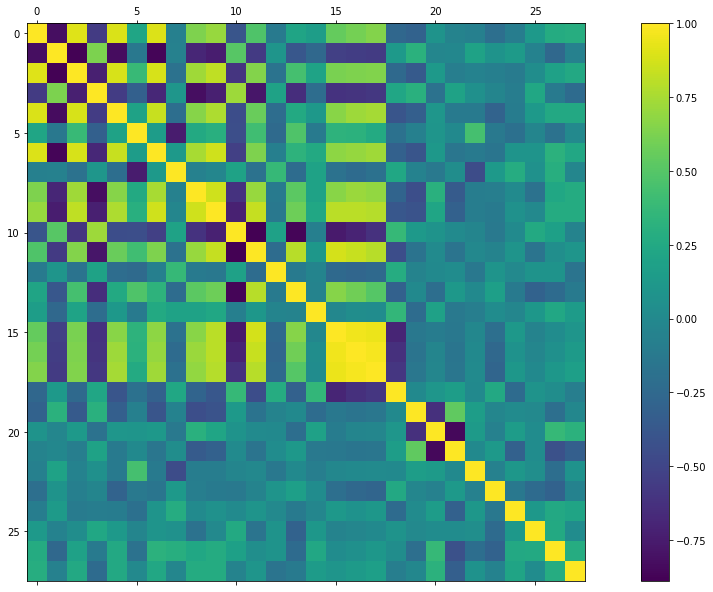

In [9]:
fig = plt.figure(figsize=(20,10))
cax = plt.matshow(fraud_df[numerical_features_only].corr(), fignum=1)
fig.colorbar(cax)

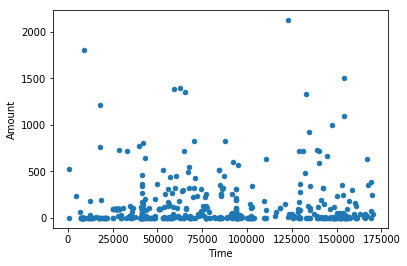

In [12]:
fraud_df.plot.scatter(x='Time', y='Amount')

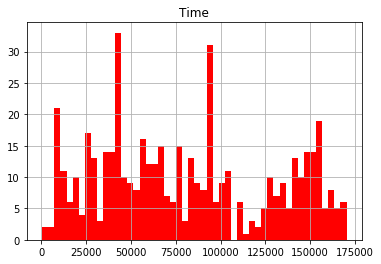

In [10]:
y = fraud_df[['Time']].hist(bins=50, color='red')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11b2bab50>]],
      dtype=object)

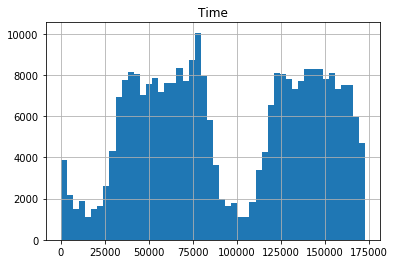

In [11]:
pdf[['Time']].hist(bins=50)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11b2bac10>]],
      dtype=object)

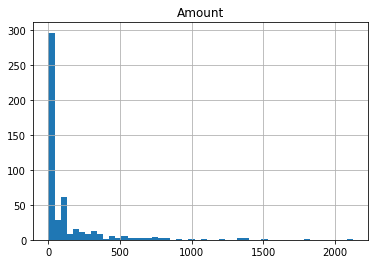

In [12]:
fraud_df[['Amount']].hist(bins=50)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11b0e9810>]],
      dtype=object)

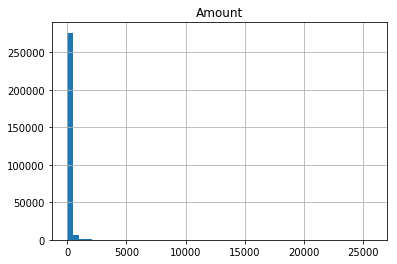

In [13]:
pdf[['Amount']].hist(bins=50)

## Data Preparation
- Dealing with imbalanced data seems to be a concern here because of the disparity of fraudalent data
    - Oversampling — SMOTE
    - Undersampling — RandomUnderSampler
    - Combined Class Methods — SMOTE + ENN
- Outlier Detection & Removal
- Dimensionality Reduction

In [14]:
def normalize(series):
    return (series - series.min()) / (series.max() - series.min())

pdf['time_normalized'] = normalize(pdf.Time)
pdf['amount_normalized'] = normalize(pdf.Amount)

In [15]:
def undersample(df):
    discriminant_feature = df.loc[df.Class == 1]
    cnt = len(discriminant_feature)
    other_set = df.loc[df.Class == 0].sample(n=cnt)
    
    together = pd.concat([discriminant_feature,other_set])
    return together.sample(frac=1)
    

balanced_df = undersample(pdf[numerical_features_only + ['time_normalized', 'amount_normalized', 'Class']])

### Split dataset into training / test

In [16]:
features = [x for x in balanced_df.columns.tolist() if x != 'Class']

X = balanced_df[features]
y = balanced_df.Class

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, random_state=0)

In [17]:
results = pd.DataFrame()

col_order = ['false_negative', 'false_positive', 'true_negative', 'true_positive', 'fraud_f1-score', 'fraud_precision', 'fraud_recall', 'not_fraud_f1-score', 'not_fraud_precision', 'not_fraud_recall']

## Helper methods for model creation

In [18]:
def train_model(model, model_name, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print('Accuracy of {model_name} on test set: {accuracy:.2f}'.format(model_name=model_name, accuracy=model.score(X_test, y_test)))
    
    return y_pred

def flatten(report):
    "used to flatten confusion matrix and classification report "
    final_dict = {}
    for k, v in report.items():
        for k2, v2 in v.items():
            if k2 in ['precision', 'recall', 'f1-score'] and k in ['not_fraud', 'fraud']:
                final_dict[k + '_' +k2] =  v2
    
    return final_dict

def analyze_model_stats(model, model_name, X_train, X_test, y_train, y_test, y_pred, results_df):
    cfmx = confusion_matrix(y_test, y_pred)
    report = classification_report(y_test, y_pred, target_names=['not_fraud', 'fraud'], output_dict=True)
    
    print 'CONFUSION MATRIX:\n',
    print(cfmx)
    print
    print 'CLASSIFICATION REPORT:'
    print(classification_report(y_test, y_pred, target_names=['not_fraud', 'fraud']))
        
    data = dict({
        'name': model_name,
        'true_positive': cfmx[0,0],
        'false_negative': cfmx[0,1],
        'false_positive': cfmx[1,0],
        'true_negative': cfmx[1,1],
    }, **flatten(report))
    
    return [data]
    
def train_and_analyze(model, model_name, X_train, X_test, y_train, y_test, results_df):
    y_pred = train_model(model, model_name, X_train, X_test, y_train, y_test)
    return analyze_model_stats(model, model_name, X_train, X_test, y_train, y_test, y_pred, results_df)

## ML Models to try out
- [**DONE**] Logistic Regression
- [**DONE**] Linear Discriminant Analysis
- [**DONE**] K Nearest Neighbors (KNN)
- [**DONE**] Classification Trees (Decision Tree, Random Forest)
- [**DONE**]Support Vector Classifier
- [**DONE**] Random Forest Classifier
- [**DONE**] XGBoost Classifier (could not get this thing to compile -- try again later)

## Logistic Regression

In [19]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression()
results = results.append(train_and_analyze(logreg, 'logistic regression', X_train, X_test, y_train, y_test, results))

Accuracy of logistic regression on test set: 0.92
CONFUSION MATRIX:
[[384   7]
 [ 58 339]]

CLASSIFICATION REPORT:
              precision    recall  f1-score   support

   not_fraud       0.87      0.98      0.92       391
       fraud       0.98      0.85      0.91       397

   micro avg       0.92      0.92      0.92       788
   macro avg       0.92      0.92      0.92       788
weighted avg       0.92      0.92      0.92       788



/Users/naveed/scratch/fraud_detection_project/venv/lib/python2.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [20]:
results.set_index('name', inplace=False)[col_order]

,false_negative,false_positive,true_negative,true_positive,fraud_f1-score,fraud_precision,fraud_recall,not_fraud_f1-score,not_fraud_precision,not_fraud_recall
name,,,,,,,,,,
logistic regression,7,58,339,384,0.912517,0.979769,0.853904,0.921969,0.868778,0.982097


## Linear Discriminant Analysis

In [21]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [22]:
lindisc = LinearDiscriminantAnalysis()
results = results.append(train_and_analyze(lindisc, 'linear discriminant', X_train, X_test, y_train, y_test, results))

Accuracy of linear discriminant on test set: 0.89
CONFUSION MATRIX:
[[385   6]
 [ 79 318]]

CLASSIFICATION REPORT:
              precision    recall  f1-score   support

   not_fraud       0.83      0.98      0.90       391
       fraud       0.98      0.80      0.88       397

   micro avg       0.89      0.89      0.89       788
   macro avg       0.91      0.89      0.89       788
weighted avg       0.91      0.89      0.89       788



In [23]:
results.set_index('name', inplace=False)[col_order]

,false_negative,false_positive,true_negative,true_positive,fraud_f1-score,fraud_precision,fraud_recall,not_fraud_f1-score,not_fraud_precision,not_fraud_recall
name,,,,,,,,,,
logistic regression,7,58,339,384,0.912517,0.979769,0.853904,0.921969,0.868778,0.982097
linear discriminant,6,79,318,385,0.882108,0.981481,0.801008,0.900585,0.829741,0.984655


## K Nearest Neighbors (KNN)

In [24]:
from sklearn.neighbors import KNeighborsClassifier

In [25]:
neigh = KNeighborsClassifier(n_neighbors=2)
results = results.append(train_and_analyze(neigh, 'k nearest neighbors', X_train, X_test, y_train, y_test, results))

Accuracy of k nearest neighbors on test set: 0.91
CONFUSION MATRIX:
[[390   1]
 [ 70 327]]

CLASSIFICATION REPORT:
              precision    recall  f1-score   support

   not_fraud       0.85      1.00      0.92       391
       fraud       1.00      0.82      0.90       397

   micro avg       0.91      0.91      0.91       788
   macro avg       0.92      0.91      0.91       788
weighted avg       0.92      0.91      0.91       788



In [26]:
results.set_index('name', inplace=False)[col_order]

,false_negative,false_positive,true_negative,true_positive,fraud_f1-score,fraud_precision,fraud_recall,not_fraud_f1-score,not_fraud_precision,not_fraud_recall
name,,,,,,,,,,
logistic regression,7,58,339,384,0.912517,0.979769,0.853904,0.921969,0.868778,0.982097
linear discriminant,6,79,318,385,0.882108,0.981481,0.801008,0.900585,0.829741,0.984655
k nearest neighbors,1,70,327,390,0.902069,0.996951,0.823678,0.916569,0.847826,0.997442


## Classification Trees

In [27]:
from sklearn.tree import DecisionTreeClassifier

In [28]:
dectree = DecisionTreeClassifier()
results = results.append(train_and_analyze(dectree, 'decision tree', X_train, X_test, y_train, y_test, results))

Accuracy of decision tree on test set: 0.89
CONFUSION MATRIX:
[[372  19]
 [ 69 328]]

CLASSIFICATION REPORT:
              precision    recall  f1-score   support

   not_fraud       0.84      0.95      0.89       391
       fraud       0.95      0.83      0.88       397

   micro avg       0.89      0.89      0.89       788
   macro avg       0.89      0.89      0.89       788
weighted avg       0.89      0.89      0.89       788



In [29]:
results.set_index('name', inplace=False)[col_order]

,false_negative,false_positive,true_negative,true_positive,fraud_f1-score,fraud_precision,fraud_recall,not_fraud_f1-score,not_fraud_precision,not_fraud_recall
name,,,,,,,,,,
logistic regression,7,58,339,384,0.912517,0.979769,0.853904,0.921969,0.868778,0.982097
linear discriminant,6,79,318,385,0.882108,0.981481,0.801008,0.900585,0.829741,0.984655
k nearest neighbors,1,70,327,390,0.902069,0.996951,0.823678,0.916569,0.847826,0.997442
decision tree,19,69,328,372,0.881720,0.945245,0.826196,0.894231,0.843537,0.951407


## Support Vector Classification

In [30]:
from sklearn import svm

In [31]:
clf = svm.SVC(kernel='rbf', C=1, gamma=0.001, random_state=1)
results = results.append(train_and_analyze(clf, 'support vectors', X_train, X_test, y_train, y_test, results))

Accuracy of support vectors on test set: 0.90
CONFUSION MATRIX:
[[391   0]
 [ 79 318]]

CLASSIFICATION REPORT:
              precision    recall  f1-score   support

   not_fraud       0.83      1.00      0.91       391
       fraud       1.00      0.80      0.89       397

   micro avg       0.90      0.90      0.90       788
   macro avg       0.92      0.90      0.90       788
weighted avg       0.92      0.90      0.90       788



In [32]:
results.set_index('name', inplace=False)[col_order]

,false_negative,false_positive,true_negative,true_positive,fraud_f1-score,fraud_precision,fraud_recall,not_fraud_f1-score,not_fraud_precision,not_fraud_recall
name,,,,,,,,,,
logistic regression,7,58,339,384,0.912517,0.979769,0.853904,0.921969,0.868778,0.982097
linear discriminant,6,79,318,385,0.882108,0.981481,0.801008,0.900585,0.829741,0.984655
k nearest neighbors,1,70,327,390,0.902069,0.996951,0.823678,0.916569,0.847826,0.997442
decision tree,19,69,328,372,0.881720,0.945245,0.826196,0.894231,0.843537,0.951407
support vectors,0,79,318,391,0.889510,1.000000,0.801008,0.908246,0.831915,1.000000


## Random Forest Classifier

In [33]:
from sklearn.ensemble import RandomForestClassifier

In [34]:
rdm = RandomForestClassifier()
results = results.append(train_and_analyze(rdm, 'random forest', X_train, X_test, y_train, y_test, results))

Accuracy of random forest on test set: 0.91
CONFUSION MATRIX:
[[390   1]
 [ 69 328]]

CLASSIFICATION REPORT:
              precision    recall  f1-score   support

   not_fraud       0.85      1.00      0.92       391
       fraud       1.00      0.83      0.90       397

   micro avg       0.91      0.91      0.91       788
   macro avg       0.92      0.91      0.91       788
weighted avg       0.92      0.91      0.91       788



/Users/naveed/scratch/fraud_detection_project/venv/lib/python2.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [35]:
results.set_index('name', inplace=False)[col_order]

,false_negative,false_positive,true_negative,true_positive,fraud_f1-score,fraud_precision,fraud_recall,not_fraud_f1-score,not_fraud_precision,not_fraud_recall
name,,,,,,,,,,
logistic regression,7,58,339,384,0.912517,0.979769,0.853904,0.921969,0.868778,0.982097
linear discriminant,6,79,318,385,0.882108,0.981481,0.801008,0.900585,0.829741,0.984655
k nearest neighbors,1,70,327,390,0.902069,0.996951,0.823678,0.916569,0.847826,0.997442
decision tree,19,69,328,372,0.881720,0.945245,0.826196,0.894231,0.843537,0.951407
support vectors,0,79,318,391,0.889510,1.000000,0.801008,0.908246,0.831915,1.000000
random forest,1,69,328,390,0.903581,0.996960,0.826196,0.917647,0.849673,0.997442


## XGBoost Classifier

In [36]:
from xgboost import XGBClassifier

In [37]:
xgb = XGBClassifier()
results = results.append(train_and_analyze(xgb, 'XGBoost', X_train, X_test, y_train, y_test, results))

Accuracy of XGBoost on test set: 0.90
CONFUSION MATRIX:
[[387   4]
 [ 72 325]]

CLASSIFICATION REPORT:
              precision    recall  f1-score   support

   not_fraud       0.84      0.99      0.91       391
       fraud       0.99      0.82      0.90       397

   micro avg       0.90      0.90      0.90       788
   macro avg       0.92      0.90      0.90       788
weighted avg       0.92      0.90      0.90       788



In [38]:
results.set_index('name', inplace=False)[col_order]

,false_negative,false_positive,true_negative,true_positive,fraud_f1-score,fraud_precision,fraud_recall,not_fraud_f1-score,not_fraud_precision,not_fraud_recall
name,,,,,,,,,,
logistic regression,7,58,339,384,0.912517,0.979769,0.853904,0.921969,0.868778,0.982097
linear discriminant,6,79,318,385,0.882108,0.981481,0.801008,0.900585,0.829741,0.984655
k nearest neighbors,1,70,327,390,0.902069,0.996951,0.823678,0.916569,0.847826,0.997442
decision tree,19,69,328,372,0.881720,0.945245,0.826196,0.894231,0.843537,0.951407
support vectors,0,79,318,391,0.889510,1.000000,0.801008,0.908246,0.831915,1.000000
random forest,1,69,328,390,0.903581,0.996960,0.826196,0.917647,0.849673,0.997442
XGBoost,4,72,325,387,0.895317,0.987842,0.818640,0.910588,0.843137,0.989770


In [39]:
results.set_index('name', inplace=False)[col_order]

,false_negative,false_positive,true_negative,true_positive,fraud_f1-score,fraud_precision,fraud_recall,not_fraud_f1-score,not_fraud_precision,not_fraud_recall
name,,,,,,,,,,
logistic regression,7,58,339,384,0.912517,0.979769,0.853904,0.921969,0.868778,0.982097
linear discriminant,6,79,318,385,0.882108,0.981481,0.801008,0.900585,0.829741,0.984655
k nearest neighbors,1,70,327,390,0.902069,0.996951,0.823678,0.916569,0.847826,0.997442
decision tree,19,69,328,372,0.881720,0.945245,0.826196,0.894231,0.843537,0.951407
support vectors,0,79,318,391,0.889510,1.000000,0.801008,0.908246,0.831915,1.000000
random forest,1,69,328,390,0.903581,0.996960,0.826196,0.917647,0.849673,0.997442
XGBoost,4,72,325,387,0.895317,0.987842,0.818640,0.910588,0.843137,0.989770


In [40]:
blah = results.copy()
blah.set_index('name', inplace=True)
blah['false_negative_normalized'] = normalize(blah['false_negative'])

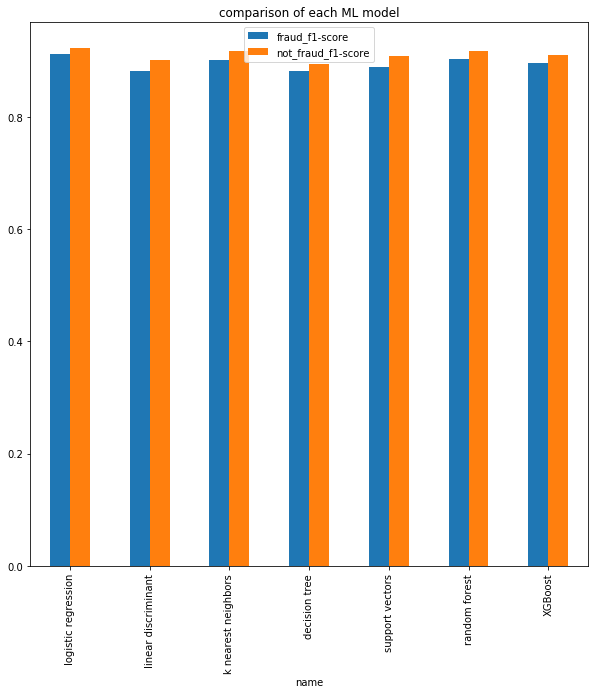

In [49]:
blah[['fraud_f1-score', 'not_fraud_f1-score']].plot(kind='bar', title='comparison of each ML model', figsize=(10,10))

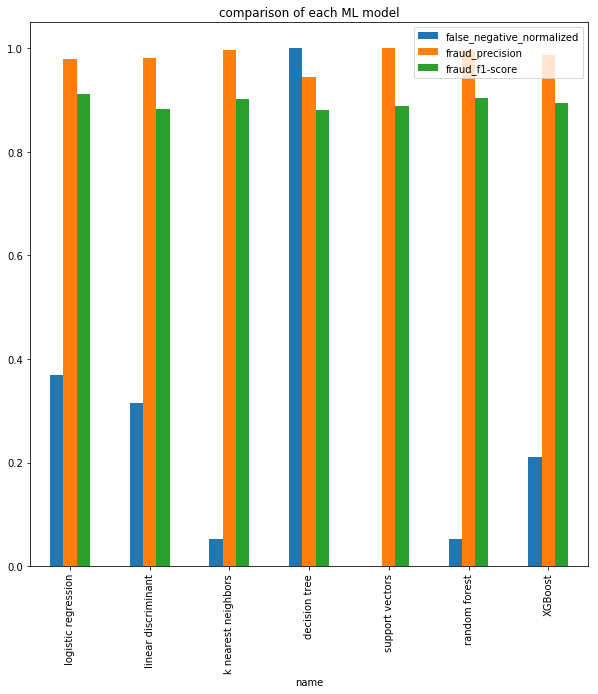

In [41]:
model_viz = blah[['false_negative_normalized', 'fraud_precision', 'fraud_f1-score']].plot(kind='bar', title='comparison of each ML model', figsize=(10,10))

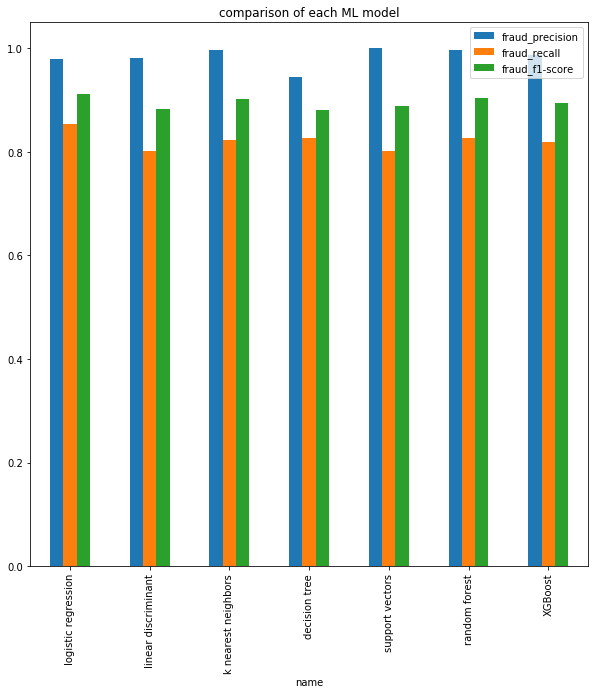

In [42]:
model_viz = blah[['fraud_precision', 'fraud_recall', 'fraud_f1-score']].plot(kind='bar', title='comparison of each ML model', figsize=(10,10))

In [50]:
    blah[['fraud_precision', 'fraud_recall', 'fraud_f1-score']].sort_values('fraud_precision', ascending=False)

,fraud_precision,fraud_recall,fraud_f1-score
name,,,
support vectors,1.000000,0.801008,0.889510
random forest,0.996960,0.826196,0.903581
k nearest neighbors,0.996951,0.823678,0.902069
XGBoost,0.987842,0.818640,0.895317
linear discriminant,0.981481,0.801008,0.882108
logistic regression,0.979769,0.853904,0.912517
decision tree,0.945245,0.826196,0.881720


In [51]:
results.to_pickle('./results/baseline.pkl')

## Baseline writeup

- wanted to see number of false negatives because i think thats the most important quadrant: makinng sure the actual numbers of fraud that go undetected is minimized is how i would define success for any given model. 
- 3 models that had the least number of false negatives: support vectors, random forest, k nearest neighbors
- XGBoost and logistic regression have the highest recall
- In the case of just having baseline data as is, i would choose svm, random forest, or knns here because the precision is high, and i am ok with the recall being a bit lower. logisitic regression may have the highest f1-score, but its less important 